# What is about ?
We look on random walks for finite symmetric groups  and we are interested how far random walk goes in "x" steps and approximation of this data by function:

$d = a * (1 - exp(-x / b))$, where:
- $x$ - step of random walk
- $a$ - asymptotic limit 
- $b$ - exponential decay term 

Approximation is made by Levenberg–Marquardt algorithm. Check here for details:
https://en.wikipedia.org/wiki/Levenberg%E2%80%93Marquardt_algorithm
https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html 

# Order of group:
We calculate statistic over S3-S8 group, because of calculation over S9 and higher requires more complex programming solution, but i think that it's possible.

# Algorithm:
- Calculate caley graph for symmetric group. **Remark**: you can use this notebook for any group from 'named_groups' in scipy
- Convert graph to networkx representation
- Start random walks and collect data
- Plot graphics and statistics over data

# Table of contents:
- #### [Preliminaries](#Preliminaries)
- #### [S3](#S3)
- #### [S4](#S4)
- #### [S5](#S5)
- #### [S6](#S6)
- #### [S7](#S7)
- #### [S8](#S8)
- #### [Approximation statistics](#Approximation-statistics)

Execution time ~40 min

# Preliminaries

In [1]:
import networkx as nx
import numpy as np
import plotly.express as px
from tqdm import tqdm
from scipy.optimize import curve_fit
from sympy.combinatorics.named_groups import SymmetricGroup
from sympy.combinatorics.named_groups import set_symmetric_group_properties
from sympy.combinatorics.permutations import Permutation
from sympy.combinatorics.perm_groups import PermutationGroup
import plotly.graph_objects as go

import matplotlib.pyplot as plt

def SymmetricGroupLRX(n):
    if n == 1:
        G = PermutationGroup([Permutation([0])])
    elif n == 2:
        G = PermutationGroup([Permutation([1, 0])])
    else:
        a = list(range(1, n))
        a.append(0)
        gen1 = Permutation._af_new(a)
        a = list(range(n))
        a[0], a[1] = a[1], a[0]
        gen2 = Permutation._af_new(a)
        a = [n-1] + list(range(0, n-1))
        gen3 = Permutation._af_new(a)
        G = PermutationGroup([gen1, gen2, gen3])
    set_symmetric_group_properties(G, n, n)
    G._is_sym = True
    return G

def generate_caley_graph(group):
    elements = group.elements
    generators = group.generators
    graph = [[((e1, e2), e1 * e2) for e2 in generators] for e1 in elements]
    return graph


def flatten(xss):
    return [x for xs in xss for x in xs]


def generate_random_path(
    G, sample_size, path_length=5, node_index=0, index_map=None, weight="weight"
):
    adj_mat = nx.to_numpy_array(G, weight=weight)
    inv_row_sums = np.reciprocal(adj_mat.sum(axis=1)).reshape(-1, 1)
    transition_probabilities = adj_mat * inv_row_sums

    node_map = np.array(G)
    num_nodes = G.number_of_nodes()

    for path_index in range(sample_size):
        # Sample current vertex v = v_i uniformly at random
        node = node_map[node_index]

        # Add v into p_r and add p_r into the path set
        # of v, i.e., P_v
        path = [node]

        # Build the inverted index (P_v) of vertices to paths
        if index_map is not None:
            if node in index_map:
                index_map[node].add(path_index)
            else:
                index_map[node] = {path_index}

        starting_index = node_index
        for _ in range(path_length):
            neighbor_index = np.random.choice(
                num_nodes, p=transition_probabilities[starting_index]
            )

            starting_index = neighbor_index

            neighbor_node = node_map[neighbor_index]
            path.append(neighbor_node)

            if index_map is not None:
                if neighbor_node in index_map:
                    index_map[neighbor_node].add(path_index)
                else:
                    index_map[neighbor_node] = {path_index}

        yield path

def create_networkx_graph_caley(group):
    caley_graph = generate_caley_graph(group)
    indexed_group_elements = dict(zip(group.elements, range(len(group.elements))))
    res = []
    for elem in caley_graph:
        res.append(
            [
                (indexed_group_elements[i[0][0]], indexed_group_elements[i[1]])
                for i in elem
            ]
        )
    edges = flatten(res)
    return nx.Graph(edges)
        
        
def calc_random_paths(group, random_walk_samples=10000, random_walk_path_length=30):
    caley_graph = create_networkx_graph_caley(group)
    distances = nx.shortest_path_length(caley_graph, source=0)
    metric = np.vectorize(lambda x: distances[x])
    random_paths = []
    generator = generate_random_path(
        caley_graph, random_walk_samples, path_length=random_walk_path_length
    )
    for path in tqdm(generator, total=random_walk_samples):
        random_paths.append(path)
        
    return metric(np.array(random_paths))


def plot_graph_caley(group):
    caley_graph = create_networkx_graph_caley(group)
    reversed_indexed_group_elements = dict(zip(range(len(group.elements)), group.elements))
    nx.draw(caley_graph, labels=reversed_indexed_group_elements)
    

def func(x, a, b):
    return a * (1 - np.exp(-x / b))
   
def calculate_stats(random_paths, group):
    stats = {}
    stats["num_trials"] = random_paths.shape[0]
    stats["random_walk_path_length"] = random_paths.shape[1]
    stats["steps"] = np.arange(0, random_paths.shape[1])
    stats["mean_distance_by_step"] = np.mean(random_paths, axis=0)
    stats["mean_distance_by_step_normalized"] = np.mean(random_paths, axis=0)/float(group.order())
    popt, _ = curve_fit(func, np.arange(0, random_paths.shape[1]), stats["mean_distance_by_step"])
    stats["coeffs"] = popt
    stats["mean_distance_by_step_approximed"] = func(np.arange(0, random_paths.shape[1]),
                                                    popt[0],
                                                    popt[1])
    
    
    return stats


def plot_graphics(stats):
    fig, ax = plt.subplots(figsize=(8, 6))

    ax.plot(stats["steps"], stats["mean_distance_by_step"],
            label="mean_distance_by_step",
            marker='o', linestyle='-', color='blue')
    
    ax.plot(stats["steps"], stats["mean_distance_by_step_approximed"],
            label="mean_distance_by_step_approximed",
            marker='s', linestyle='--', color='orange')
    
    ax.set_title(f"Num trials: {stats['num_trials']}",
                 fontsize=12, fontname="Courier New", color="RebeccaPurple")
    
    ax.set_xlabel("Steps", fontsize=10, fontname="Courier New", color="RebeccaPurple")
    ax.set_ylabel("Distance", fontsize=10, fontname="Courier New", color="RebeccaPurple")
    
    ax.tick_params(axis='both', which='major', labelsize=10, labelcolor="RebeccaPurple")
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)
    
    fig.tight_layout()
    plt.show()

results = {}


### S3 LRX

100%|██████████| 3000/3000 [00:20<00:00, 148.53it/s]


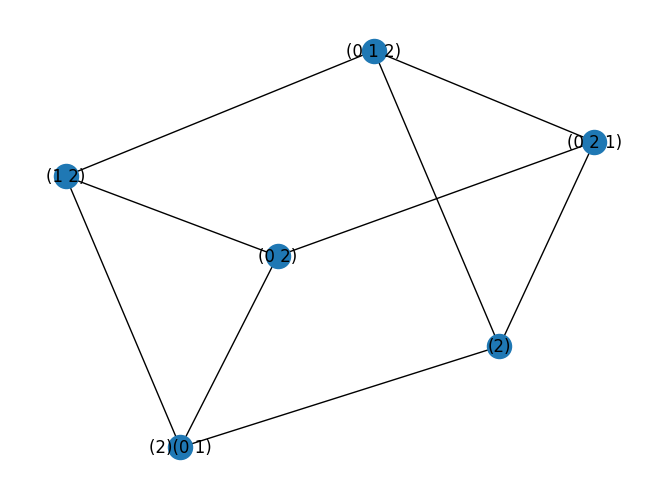

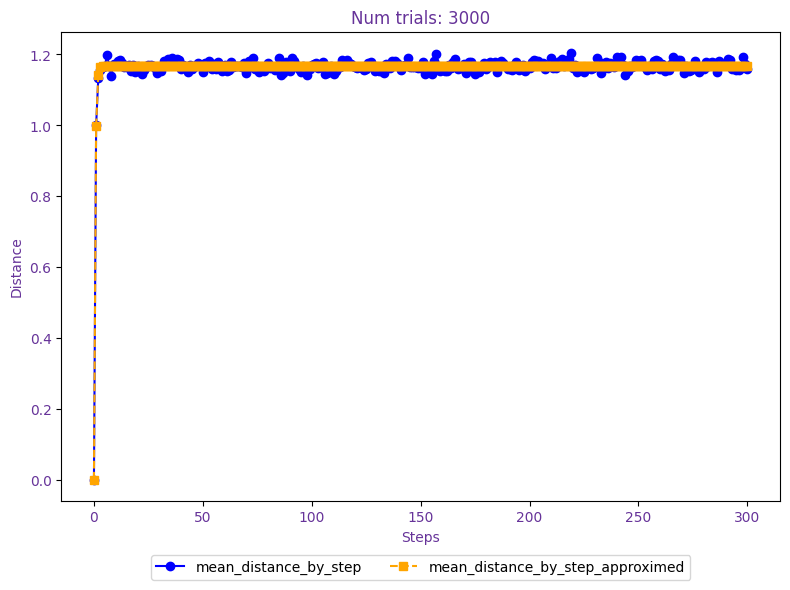

In [2]:
# Create the Symmetric Group 3
ORDER_OF_GROUP = 3
RANDOM_WALK_SAMPLES = 3000
RANDOM_WALK_PATH_LENGTH = 300
PLOT_GRAPH = True

group = SymmetricGroupLRX(ORDER_OF_GROUP)
random_paths = calc_random_paths(group, RANDOM_WALK_SAMPLES, RANDOM_WALK_PATH_LENGTH)
stats = calculate_stats(random_paths, group)
results[f"S_LRX_{ORDER_OF_GROUP}"] = stats
if PLOT_GRAPH:
    plot_graph_caley(group)
plot_graphics(stats)

### S3

100%|██████████| 3000/3000 [00:20<00:00, 144.13it/s]


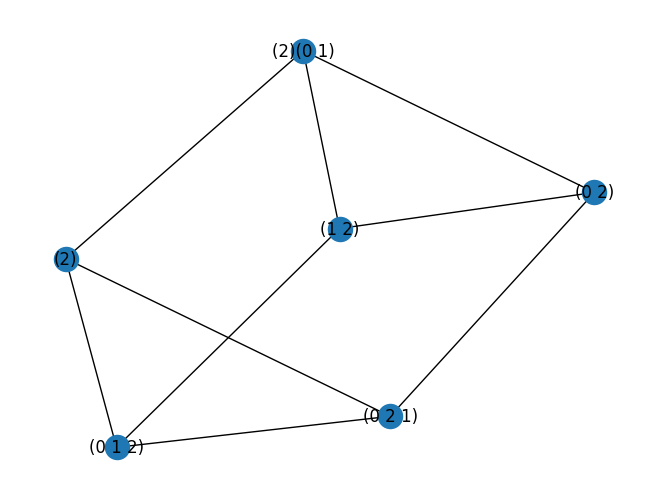

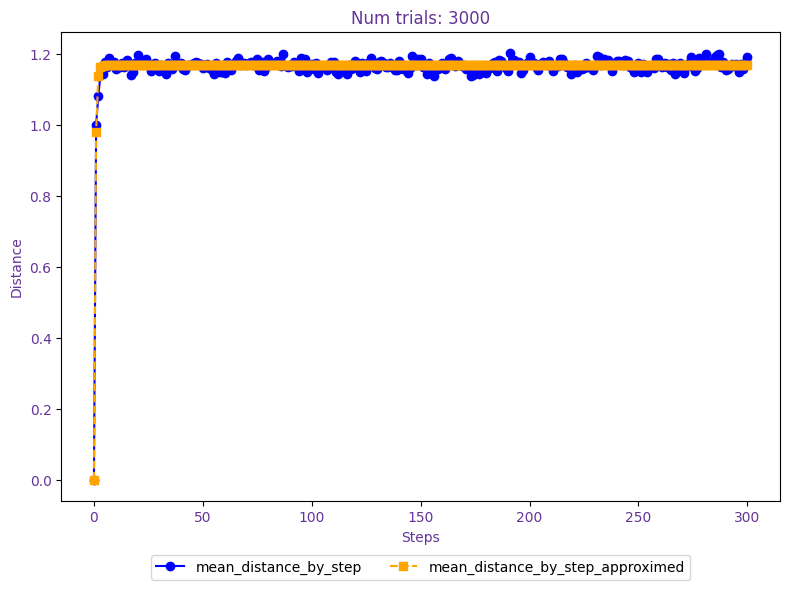

In [3]:
# Create the Symmetric Group 3
ORDER_OF_GROUP = 3
RANDOM_WALK_SAMPLES = 3000
RANDOM_WALK_PATH_LENGTH = 300
PLOT_GRAPH = True

group = SymmetricGroup(ORDER_OF_GROUP)
random_paths = calc_random_paths(group, RANDOM_WALK_SAMPLES, RANDOM_WALK_PATH_LENGTH)
stats = calculate_stats(random_paths, group)
results[f"S_{ORDER_OF_GROUP}"] = stats
if PLOT_GRAPH:
    plot_graph_caley(group)
plot_graphics(stats)

### S4 LRX

In [ ]:
# Create the Symmetric Group 4 LRX
ORDER_OF_GROUP = 4
RANDOM_WALK_SAMPLES = 3000
RANDOM_WALK_PATH_LENGTH = 300
PLOT_GRAPH = True

group = SymmetricGroupLRX(ORDER_OF_GROUP)
random_paths = calc_random_paths(group, RANDOM_WALK_SAMPLES, RANDOM_WALK_PATH_LENGTH)
stats = calculate_stats(random_paths, group)
results[f"S_LRX_{ORDER_OF_GROUP}"] = stats
if PLOT_GRAPH:
    plot_graph_caley(group)
plot_graphics(stats)

### S4

In [ ]:
# Create the Symmetric Group 4
ORDER_OF_GROUP = 4
RANDOM_WALK_SAMPLES = 3000
RANDOM_WALK_PATH_LENGTH = 300
PLOT_GRAPH = True

group = SymmetricGroup(ORDER_OF_GROUP)
random_paths = calc_random_paths(group, RANDOM_WALK_SAMPLES, RANDOM_WALK_PATH_LENGTH)
stats = calculate_stats(random_paths, group)
results[f"S_{ORDER_OF_GROUP}"] = stats
if PLOT_GRAPH:
    plot_graph_caley(group)
plot_graphics(stats)

### S5 LRX

In [ ]:
# Create the Symmetric Group 5 LRX
ORDER_OF_GROUP = 5
RANDOM_WALK_SAMPLES = 3000
RANDOM_WALK_PATH_LENGTH = 300
PLOT_GRAPH = False

group = SymmetricGroupLRX(ORDER_OF_GROUP)
random_paths = calc_random_paths(group, RANDOM_WALK_SAMPLES, RANDOM_WALK_PATH_LENGTH)
stats = calculate_stats(random_paths, group)
results[f"S_LRX_{ORDER_OF_GROUP}"] = stats
if PLOT_GRAPH:
    plot_graph_caley(group)
plot_graphics(stats)

### S5

In [ ]:
# Create the Symmetric Group 5
ORDER_OF_GROUP = 5
RANDOM_WALK_SAMPLES = 3000
RANDOM_WALK_PATH_LENGTH = 300
PLOT_GRAPH = False

group = SymmetricGroup(ORDER_OF_GROUP)
random_paths = calc_random_paths(group, RANDOM_WALK_SAMPLES, RANDOM_WALK_PATH_LENGTH)
stats = calculate_stats(random_paths, group)
results[f"S_{ORDER_OF_GROUP}"] = stats
if PLOT_GRAPH:
    plot_graph_caley(group)
plot_graphics(stats)

### S6 LRX

In [ ]:
# Create the Symmetric Group 6 LRX
ORDER_OF_GROUP = 6
RANDOM_WALK_SAMPLES = 3000
RANDOM_WALK_PATH_LENGTH = 300
PLOT_GRAPH = False

group = SymmetricGroupLRX(ORDER_OF_GROUP)
random_paths = calc_random_paths(group, RANDOM_WALK_SAMPLES, RANDOM_WALK_PATH_LENGTH)
stats = calculate_stats(random_paths, group)
results[f"S_LRX_{ORDER_OF_GROUP}"] = stats
if PLOT_GRAPH:
    plot_graph_caley(group)
plot_graphics(stats)

### S6

In [ ]:
# Create the Symmetric Group 6
ORDER_OF_GROUP = 6
RANDOM_WALK_SAMPLES = 3000
RANDOM_WALK_PATH_LENGTH = 300
PLOT_GRAPH = False

group = SymmetricGroup(ORDER_OF_GROUP)
random_paths = calc_random_paths(group, RANDOM_WALK_SAMPLES, RANDOM_WALK_PATH_LENGTH)
stats = calculate_stats(random_paths, group)
results[f"S_{ORDER_OF_GROUP}"] = stats
if PLOT_GRAPH:
    plot_graph_caley(group)
plot_graphics(stats)

### S7 LRX

In [ ]:
# Create the Symmetric Group 7 LRX
ORDER_OF_GROUP = 7
RANDOM_WALK_SAMPLES = 3000
RANDOM_WALK_PATH_LENGTH = 300
PLOT_GRAPH = False

group = SymmetricGroupLRX(ORDER_OF_GROUP)
random_paths = calc_random_paths(group, RANDOM_WALK_SAMPLES, RANDOM_WALK_PATH_LENGTH)
stats = calculate_stats(random_paths, group)
results[f"S_LRX_{ORDER_OF_GROUP}"] = stats
if PLOT_GRAPH:
    plot_graph_caley(group`)
plot_graphics(stats)

### S7

In [ ]:
# Create the Symmetric Group 7
ORDER_OF_GROUP = 7
RANDOM_WALK_SAMPLES = 3000
RANDOM_WALK_PATH_LENGTH = 300
PLOT_GRAPH = False

group = SymmetricGroup(ORDER_OF_GROUP)
random_paths = calc_random_paths(group, RANDOM_WALK_SAMPLES, RANDOM_WALK_PATH_LENGTH)
stats = calculate_stats(random_paths, group)
results[f"S_{ORDER_OF_GROUP}"] = stats
if PLOT_GRAPH:
    plot_graph_caley(group)
plot_graphics(stats)

In [ ]:
# Create the Symmetric Group 8 LRX
ORDER_OF_GROUP = 8
RANDOM_WALK_SAMPLES = 3000
RANDOM_WALK_PATH_LENGTH = 300
PLOT_GRAPH = False

group = SymmetricGroupLRX(ORDER_OF_GROUP)
random_paths = calc_random_paths(group, RANDOM_WALK_SAMPLES, RANDOM_WALK_PATH_LENGTH)
stats = calculate_stats(random_paths, group)
results[f"S_LRX_{ORDER_OF_GROUP}"] = stats
if PLOT_GRAPH:
    plot_graph_caley(group)
plot_graphics(stats)

# Approximation statistics

### Asymptotic limit by order group

In [ ]:
import matplotlib.pyplot as plt

filtered_results = {k: v for k, v in results.items() if k.startswith("S_LRX_")}

# Assuming `results` is defined
x_values = list(filtered_results.keys())
y_values = [v["coeffs"][0] for v in filtered_results.values()]

fig, ax = plt.subplots()
ax.plot(x_values, y_values, marker='o', linestyle='-', markersize=8)

# Add text labels for each point
for i, txt in enumerate(x_values):
    ax.text(x_values[i], y_values[i], txt, fontsize=9, ha='right', va='bottom')

ax.set_title("Asymptotic limit for symmetric LRX group")
ax.set_xlabel("Group")
ax.set_ylabel("Asymptotic limit")
plt.show()

### Amount of steps to plateu

In [ ]:
def x_plateau_percent(b, target_fraction):
    return -b * np.log(1 - target_fraction)

def x_power_a(x, a, b):
    return x**a + b

target_fraction = 0.999
filtered_results = {k: v for k, v in results.items() if k.startswith("S_LRX_")}

x_values = list(filtered_results.keys())
y_values = [x_plateau_percent(v["coeffs"][1],target_fraction)  for v in filtered_results.values()]

x = np.arange(3, len(y_values) + 3)
popt, pcov = curve_fit(x_power_a, x, y_values)
a_opt, b_opt = popt

y_values_approximated = [x_power_a(value, a_opt, b_opt) for value in x]

fig, ax = plt.subplots()
ax.plot(x_values, y_values, marker='o', linestyle='-', markersize=8)
ax.plot(x_values, y_values_approximated, marker='o', linestyle='-', markersize=8)

# Add text labels for each point
for i, txt in enumerate(x_values):
    ax.text(x_values[i], y_values[i], txt, fontsize=9, ha='right', va='bottom')

ax.set_title("Number steps to plateu")
ax.set_xlabel("Group")
ax.set_ylabel("Steps")
plt.show()

print(f"Estimated parameter a: {a_opt:.4f}")
print(f"Estimated parameter b: {b_opt:.4f}")
print(f"Number steps to plateu: {y_values}")